## Orbit bechmarking notebook

The purpose of this notebook is to benchmark **Orbit** models (mainly `LGT` model with `MAP`/`MCMC` method) against **Prophet** model on both internal and external datasets.


In [1]:
import pandas as pd
import numpy as np
import time
import pickle
import os

from fbprophet import Prophet
import inspect

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('ggplot')

import sys
sys.path.append("../../uTS")
from uTS.lgt import LGT
from uTS.dlt import DLT
from uTS.backtest import BacktestEngine, mape, smape, wmape

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


Here we define a utility function particularly for this model benchmarking notebook, since each data set may consist of multiple time series.

In [2]:
def analyze_utility(data, geo_col, city_name_list, pred_cols,
                    mod_list, model_callbacks, fit_callbacks, pred_callbacks,
                    date_col, resp_col, min_train_len, incremental_len, forecast_len,
                    transform_fun = None, metric_fun = 'mape',
                    start_date=None, end_date=None,
                    keep_cols = None, regressor_col=None,
                    mod_names = None, to_save_as = None,
                    scheme = 'expanding'):
    metric_dict = {}
    assert len(mod_list) == len(pred_cols), 'check if the model list is consistent with the prediction columns'
    if mod_names is not None:
        assert len(mod_list) == len(mod_names)
    all_res = []
    for i, mod in enumerate(mod_list):
        idxer = i if mod_names is None else mod_names[i]
        metric_dict[idxer] = {}
        res = []
        tic = time.time()
        for city in city_name_list:
            df = data[data[geo_col] == city]
            bt_expand = BacktestEngine(mod, df, date_col=date_col, response_col=resp_col, 
                           model_callbacks=model_callbacks[i])

            bt_expand.create_meta(min_train_len, incremental_len, forecast_len, 
                                       start_date=start_date, end_date=end_date, keep_cols=keep_cols,
                                       scheme=scheme)

            bt_expand.run(verbose=False, save_results=False, 
                          fit_callbacks=fit_callbacks[i], pred_callbacks=pred_callbacks[i], pred_col=pred_cols[i], 
                          date_col=date_col, response_col=resp_col, regressor_col=regressor_col)
            tmp = bt_expand.bt_res

            res.append(tmp)
    
        res = pd.concat(res, axis=0, ignore_index=True)
        if mod_names is not None:
            res['model'] = mod_names[i]
        all_res.append(res)
        if transform_fun is not None:
            res[['actual', 'pred']] = res[['actual', 'pred']].apply(transform_fun)
        
        # N-step ahead, N=1, 12, 52; sum over geo's
        metric_weekly = res.groupby(['train_end_date', geo_col]).head(1).\
            groupby(['train_end_date', 'pred_horizon'])['actual', 'pred'].sum().\
            groupby('train_end_date').apply(lambda x: eval(metric_fun)(x['actual'], x['pred'])).mean()
        metric_quarterly = res.groupby(['train_end_date', geo_col]).head(12).\
            groupby(['train_end_date', 'pred_horizon'])['actual', 'pred'].sum().\
            groupby('train_end_date').apply(lambda x: eval(metric_fun)(x['actual'], x['pred'])).mean()
        metric_yearly = res.groupby(['train_end_date', 'pred_horizon'])['actual', 'pred'].sum()\
            .groupby('train_end_date').apply( lambda x: eval(metric_fun)(x['actual'], x['pred'])).mean()
        metric_geo = res.groupby(geo_col).apply(lambda x: eval(metric_fun)(x['actual'], x['pred']))
        metric_horizon = res.groupby('pred_horizon').\
            apply(lambda x: eval(metric_fun)(x['actual'], x['pred']))

        toc = time.time()
        metric_dict[idxer]['metric_weekly'] = metric_weekly
        metric_dict[idxer]['metric_quarterly'] = metric_quarterly
        metric_dict[idxer]['metric_yearly'] = metric_yearly
        metric_dict[idxer]['metric_geo'] = metric_geo
        metric_dict[idxer]['metric_horizon'] = metric_horizon
        metric_dict[idxer]['exe_time'] = time.strftime("%H:%M:%S", time.gmtime(toc - tic))
        
        print('time elapsed {}'.format(time.strftime("%H:%M:%S", time.gmtime(toc - tic))))
    
    all_res = pd.concat(all_res, axis=0, ignore_index=True)
    if to_save_as is not None:
        outdir = os.getcwd() + '/orbit_benchmark_results'
        os.makedirs(outdir, exist_ok=True)
        outfile = outdir + '/orbit_benchmark_{}'.format(to_save_as) + '.pickle'
        benchmark_out = {
            'benchmark_metrics': metric_dict,
            'benchmark_results': all_res
        }
        print('saving results to', outfile)
        with open(outfile, 'wb') as handle:
            pickle.dump(benchmark_out, handle)
    return metric_dict, all_res


Below we define callbacks for prophet model object which will be used later.

In [3]:
def model_callbacks_prophet(model):
    def _get_params(instance):
        """get initilization parameters via a prophet model object"""
        class_hierarchy = inspect.getmro(Prophet)
        init_signatures = [inspect.signature(c.__init__) for c in class_hierarchy if type(c) is not object]

        all_params = []
        for sig in init_signatures:
            params = [p for p in sig.parameters.values()
                      if p.name != 'self' and p.kind != p.VAR_KEYWORD
                      and p.kind != p.VAR_POSITIONAL]
            all_params.extend(params)
        param_names = [p.name for p in all_params]
        out = dict()
        for key in param_names:
            out[key] = getattr(instance, key)

        return out

    def bind(instance, _get_params):
        def binding_scope_fn(): 
            return _get_params(instance)
        return binding_scope_fn
    model.get_params = bind(model, _get_params)
    
    return model


def fit_callbacks_prophet(model, train_df, date_col, response_col, regressor_col):
    train_df = train_df.rename(columns={date_col: "ds", response_col: "y"})
    if regressor_col is not None:
        for regressor in regressor_col:
            model.add_regressor(regressor) 
    model.fit(train_df)
    
    return 

def pred_callbacks_prophet(model, test_df, date_col, response_col, regressor_col):
    test_df = test_df.rename(columns={date_col: "ds", response_col: "y"})
    
    return model.predict(test_df)

In the following sections, we will test 3 modesl across 4 datasets, two internal and two external. Here we set up a data frame to track the quantities of interest.

In [12]:
model_names = ["LGT-MAP",  "DLT-MAP", "Prophet"]
# model_names = ["LGT-MAP",  "LGT-MCMC", "Prophet"]
cols = pd.MultiIndex.from_arrays([['weekly']*3 + ['quarterly']*3 + ['yearly']*3 + ['exe_time']*3, 
                                    model_names*4],
                                    names=['wmape', 'model'])

bt_summary = pd.DataFrame({},
                      index = pd.Index(['driver', 'rider', 'iclaims', 'M4'], name = 'dataset'),
                      columns = cols)


## (internal) weekly driver uFT

In [13]:
## for each city, there are 170 weekly data points, spanning from 2016-07-04 to 2019-09-30; 42 cities in total
data_path = "./data/driver_weekly_uFT.csv"
var_type = 'uFT'

raw_data = pd.read_csv(data_path, parse_dates=['event_week'])
data = raw_data.copy()
data = data[data['var_type'] == var_type]
data['metrics'] = data['metrics'].map(np.log)

In [14]:
data.head(5)

,event_week,var_type,city_id,city_name,metrics
42,2016-07-04,uFT,1,San Francisco,6.963190
43,2016-07-04,uFT,4,Austin,3.713572
44,2016-07-04,uFT,5,New York City,6.236370
45,2016-07-04,uFT,6,Boston,6.298949
46,2016-07-04,uFT,7,Chicago,7.419381


In [15]:
date_col = 'event_week'
resp_col = 'metrics'

min_train_len = 98
forecast_len = 52
incremental_len = 10

geo_col = 'city_name'
keep_cols = ['city_name']
city_name_list =  data['city_name'].unique() ## ['San Francisco'] 
scheme = 'expanding'
transform_fun = np.exp

# pred_cols = ['prediction', 50, 'yhat']
pred_cols = ['prediction', 'prediction', 'yhat']
model_callbacks = [None]*2 + [model_callbacks_prophet]
fit_callbacks = [None]*2 + [fit_callbacks_prophet]
pred_callbacks = [None]*2 + [pred_callbacks_prophet]

mod_list = [ 
    
    ## vanilla LGT
    LGT(response_col = resp_col,
        date_col = date_col,
        seasonality = 52,
        seed = 1,
        predict_method = 'map'
),
#     LGT(response_col=resp_col,
#         date_col=date_col,
#         seasonality=52,
#         num_warmup=1000, 
#         num_sample=2000,
#         predict_method='full', ## full/mean/median/map, 
#         sample_method='mcmc',## vi
#         n_bootstrap_draws=-1,
#         seed = 1
# ),
    DLT(response_col=resp_col,
        date_col=date_col,
        seasonality=52,
        num_warmup=1000, 
        num_sample=2000,
        predict_method = 'map',
        damped_factor_fixed=-1,
        seed = 1
),
    ## fb prophet
    Prophet() ## by default fit weekly and yearly seasonalities
    
]

In [16]:
np.random.seed(2019) ## to have full reproducibility for mcmc samples
wmape_dict_driver, bt_res_driver = analyze_utility(data, geo_col, city_name_list, pred_cols,
                        mod_list, model_callbacks, fit_callbacks, pred_callbacks,
                        date_col, resp_col, min_train_len, incremental_len, forecast_len, 
                        transform_fun, metric_fun = 'wmape',
                        start_date=None, end_date=None,
                        keep_cols = keep_cols, 
                        mod_names = model_names, to_save_as = 'driver',
                        scheme = scheme)

 33%|███▎      | 1/3 [00:00<00:00,  9.04it/s]

time elapsed 00:00:10


  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time elapsed 00:00:13


 33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:02,  2.05s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
IN

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.96s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:04<00:02,  2.09s/it]INFO

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:02<00:04,  2.21s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:02,  2.05s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbproph

time elapsed 00:03:56
saving results to /Users/edwinng/work/uTS-super/uTS-py/uTS/examples/orbit_benchmark_results/orbit_benchmark_driver.pickle


In [19]:
for i, key in enumerate(wmape_dict_driver.keys()):
    bt_summary.iloc[0, list(range(i, bt_summary.shape[1], 3))] = \
                                [ wmape_dict_driver[key]['metric_weekly'], # 1 step ahead
                                    wmape_dict_driver[key]['metric_quarterly'],
                                    wmape_dict_driver[key]['metric_yearly'],
                                    wmape_dict_driver[key]['exe_time'] ]
    
bt_summary.loc['driver'].to_frame()

driver
wmape     model             
weekly    LGT-MAP  0.0473308
          DLT-MAP  0.0471125
          Prophet  0.0597898
quarterly LGT-MAP  0.0794364
          DLT-MAP  0.0796981
          Prophet  0.0966086
yearly    LGT-MAP   0.113997
          DLT-MAP   0.132284
          Prophet   0.132051
exe_time  LGT-MAP   00:00:10
          DLT-MAP   00:00:13
          Prophet   00:03:56

In [20]:
bt_res_driver.head()

,train_start_date,train_end_date,forecast_dates,actual,pred,pred_horizon,city_name,model
0,2016-07-04,2018-05-14,2018-05-21,527.0,470.602116,1,San Francisco,LGT-MAP
1,2016-07-04,2018-05-14,2018-05-28,454.0,444.570507,2,San Francisco,LGT-MAP
2,2016-07-04,2018-05-14,2018-06-04,471.0,507.892295,3,San Francisco,LGT-MAP
3,2016-07-04,2018-05-14,2018-06-11,510.0,486.592194,4,San Francisco,LGT-MAP
4,2016-07-04,2018-05-14,2018-06-18,591.0,440.613350,5,San Francisco,LGT-MAP


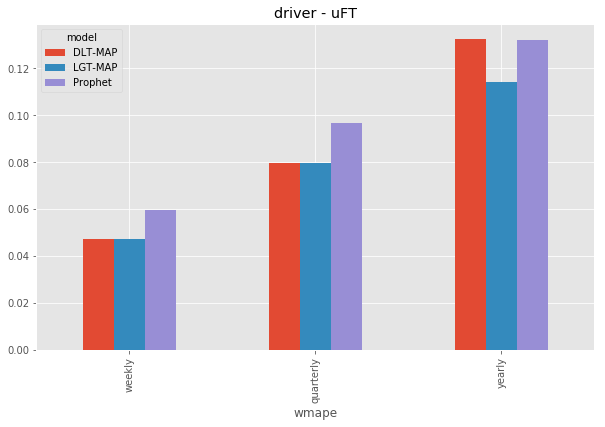

In [21]:
bt_summary.loc['driver'].unstack().iloc[[2,1,3],].apply(pd.to_numeric).plot(kind='bar', 
                                                                       stacked=False,
                                                                       figsize=(10,6), title='driver - uFT')

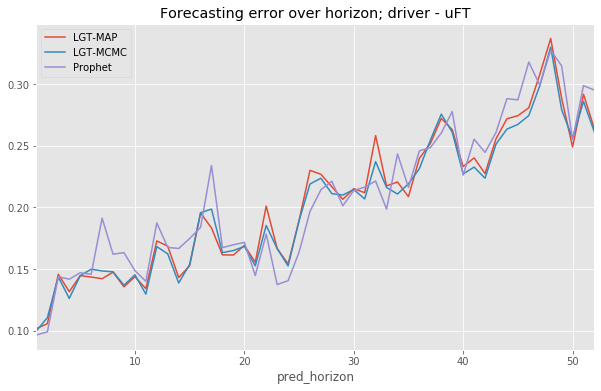

In [26]:
pd.concat((wmape_dict_driver['LGT-MAP']['metric_horizon'], 
           wmape_dict_driver['LGT-MCMC']['metric_horizon'],
           wmape_dict_driver['Prophet']['metric_horizon']), axis=1, keys=model_names).\
                                            plot(figsize=(10,6),
                                                 title='Forecasting error over horizon; driver - uFT')

## (internal) weekly rider uFT

In [34]:
data_path = "./data/rider_weekly_uFT.csv"
var_type = 'uFT'

raw_data = pd.read_csv(data_path, parse_dates=['event_week'])
data = raw_data.copy()
data = data[data['var_type'] == var_type]
data['metrics'] = data['metrics'].map(np.log)

In [35]:
date_col = 'event_week'
resp_col = 'metrics'
min_train_len = 98
forecast_len = 52
incremental_len = 10

geo_col = 'city_name'
keep_cols = ['city_name']
city_name_list = data['city_name'].unique() ## ['San Francisco'] 
scheme = 'expanding'
transform_fun = np.exp

# pred_cols = ['prediction', 50, 'yhat']
model_callbacks = [None]*2 + [model_callbacks_prophet]
fit_callbacks = [None]*2 + [fit_callbacks_prophet]
pred_callbacks = [None]*2 + [pred_callbacks_prophet]

mod_list = [ 
    
    ## vanilla LGT
    LGT(response_col = resp_col,
        date_col = date_col,
        seasonality = 52,
        seed = 1,
        predict_method = 'map'
),
#     LGT(response_col=resp_col,
#         date_col=date_col,
#         seasonality=52,
#         num_warmup=1000, 
#         num_sample=2000,
#         predict_method='full', ## full/mean/median/map, 
#         sample_method='mcmc',## vi
#         n_bootstrap_draws=-1,
#         seed = 1
# ),
    DLT(response_col=resp_col,
        date_col=date_col,
        seasonality=52,
        num_warmup=1000, 
        num_sample=2000,
        predict_method = 'map',
        damped_factor_fixed=-1,
        seed = 1
),
    ## fb prophet
    Prophet()
    
]

In [36]:
np.random.seed(2019) ## to have full reproducibility for mcmc samples
wmape_dict_rider, bt_res_rider = analyze_utility(data, geo_col, city_name_list, pred_cols,
                        mod_list, model_callbacks, fit_callbacks, pred_callbacks,
                        date_col, resp_col, min_train_len, incremental_len, forecast_len, 
                        transform_fun, metric_fun = 'wmape',
                        start_date=None, end_date=None,
                        keep_cols = keep_cols,
                        mod_names = model_names, to_save_as = 'rider',
                        scheme = scheme)

 33%|███▎      | 1/3 [00:00<00:00,  6.41it/s]

time elapsed 00:00:10


  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time elapsed 00:00:15


 33%|███▎      | 1/3 [00:02<00:04,  2.24s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:02,  2.05s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:02<00:05,  2.55s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
IN

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:02,  2.03s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:01<00:03,  2.00s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.89s/it]INFO

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:02<00:04,  2.13s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.98s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbproph

time elapsed 00:03:44
saving results to /Users/edwinng/work/uTS-super/uTS-py/uTS/examples/orbit_benchmark_results/orbit_benchmark_rider.pickle


In [37]:
for i, key in enumerate(wmape_dict_rider.keys()):
    bt_summary.iloc[1, list(range(i, bt_summary.shape[1], 3))] = \
                                [ wmape_dict_rider[key]['metric_weekly'],  
                                    wmape_dict_rider[key]['metric_quarterly'],
                                    wmape_dict_rider[key]['metric_yearly'],
                                    wmape_dict_rider[key]['exe_time'] ]
    
bt_summary.loc['rider'].to_frame()

rider
wmape     model             
weekly    LGT-MAP  0.0193926
          DLT-MAP  0.0178384
          Prophet  0.0136503
quarterly LGT-MAP  0.0403234
          DLT-MAP   0.037246
          Prophet  0.0413404
yearly    LGT-MAP  0.0710126
          DLT-MAP   0.087378
          Prophet   0.133919
exe_time  LGT-MAP   00:00:10
          DLT-MAP   00:00:15
          Prophet   00:03:44

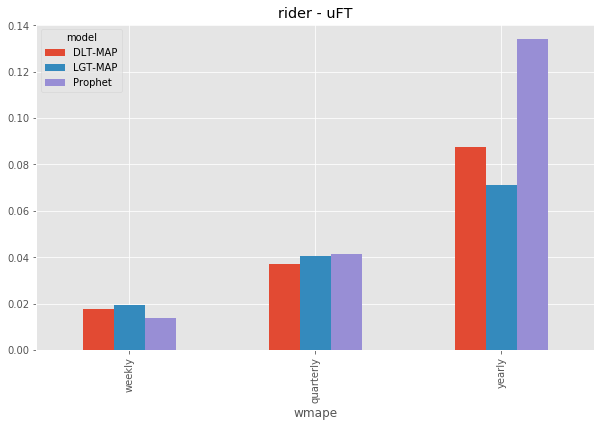

In [38]:
bt_summary.loc['rider'].unstack().iloc[[2,1,3],].apply(pd.to_numeric).plot(kind='bar', 
                                                                       stacked=False,
                                                                       figsize=(10,6), title='rider - uFT')

## (external) iclaims insurance dataset

In [15]:
data_path = "./data/iclaims.example.csv"
raw_data = pd.read_csv(data_path, parse_dates=['week'])

data = raw_data.copy()
data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']] = \
    data[['claims', 'trend.unemploy', 'trend.filling', 'trend.job']].apply(np.log, axis = 1)

data['city_name'] = 'TBD'
print(data.shape)
data.head(5)

(443, 6)


,week,claims,trend.unemploy,trend.filling,trend.job,city_name
0,2010-01-03,13.386595,0.168876,-0.328309,0.113033,TBD
1,2010-01-10,13.624218,0.168876,-0.204695,0.164326,TBD
2,2010-01-17,13.398741,0.185136,-0.302334,0.113033,TBD
3,2010-01-24,13.137549,0.152346,-0.204695,0.102451,TBD
4,2010-01-31,13.196760,0.083354,-0.252323,0.070016,TBD


In [16]:
date_col = 'week'
resp_col = 'claims'
min_train_len = 350
forecast_len = 52
incremental_len = 10

geo_col = 'city_name'
keep_cols = ['city_name']
city_name_list = data['city_name'].unique()
scheme = 'expanding'
transform_fun = np.exp

# pred_cols = ['prediction', 50, 'yhat']
model_callbacks = [None]*2 + [model_callbacks_prophet]
fit_callbacks = [None]*2 + [fit_callbacks_prophet]
pred_callbacks = [None]*2 + [pred_callbacks_prophet]

mod_list = [ 
    
    ## vanilla LGT
    LGT(response_col = resp_col,
        date_col = date_col,
        seasonality = 52,
        seed = 1,
        predict_method = 'map'
),
    LGT(response_col=resp_col,
        date_col=date_col,
        seasonality=52,
        num_warmup=1000, 
        num_sample=2000,
        predict_method='full', ## full/mean/median/map, 
        sample_method='mcmc',## vi
        n_bootstrap_draws=-1,
        seed = 1
),
    ## fb prophet
    Prophet()
]

In [17]:
np.random.seed(2019)
wmape_dict_iclaims, bt_res_iclaims = analyze_utility(data, geo_col, city_name_list, pred_cols,
                        mod_list, model_callbacks, fit_callbacks, pred_callbacks,
                        date_col, resp_col, min_train_len, incremental_len, forecast_len, 
                        transform_fun, metric_fun = 'wmape',
                        start_date=None, end_date=None,
                        keep_cols = keep_cols,
                        mod_names = model_names, to_save_as = 'iclaims',
                        scheme = scheme)

  0%|          | 0/5 [00:00<?, ?it/s]

time elapsed 00:00:00


To run all diagnostics call pystan.check_hmc_diagnostics(fit)
 20%|██        | 1/5 [00:08<00:35,  8.81s/it]WARNING:pystan:Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
 40%|████      | 2/5 [00:17<00:26,  8.69s/it]WARNING:pystan:Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
 60%|██████    | 3/5 [00:28<00:19,  9.54s/it]WARNING:pystan:Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
 80%|████████  | 4/5 [00:42<00:10, 10.87s/it]WARNING:pystan:Maximum (flat) parameter count (1000) exceeded: skipping diagnostic tests for n_eff and Rhat.
To run all diagnostics call pystan.check_hmc_diagnostics(fit)
  0%|          | 0/5 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seaso

time elapsed 00:00:55


 20%|██        | 1/5 [00:01<00:05,  1.47s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 40%|████      | 2/5 [00:02<00:04,  1.47s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 60%|██████    | 3/5 [00:04<00:02,  1.46s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 80%|████████  | 4/5 [00:05<00:01,  1.43s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override th

time elapsed 00:00:07
saving results to /Users/zhishiw/Desktop/uTS-py/uTS/examples/orbit_benchmark_results/orbit_benchmark_iclaims.pickle


In [18]:
for i, key in enumerate(wmape_dict_iclaims.keys()):
    bt_summary.iloc[2, list(range(i, bt_summary.shape[1], 3))] = \
                                [ wmape_dict_iclaims[key]['metric_weekly'],  
                                    wmape_dict_iclaims[key]['metric_quarterly'],
                                    wmape_dict_iclaims[key]['metric_yearly'],
                                    wmape_dict_iclaims[key]['exe_time'] ]
    
bt_summary.loc['iclaims'].to_frame()

iclaims
wmape     model              
weekly    LGT-MAP   0.0142237
          LGT-MCMC  0.0136211
          Prophet   0.0535138
quarterly LGT-MAP   0.0545708
          LGT-MCMC  0.0528193
          Prophet   0.0553223
yearly    LGT-MAP   0.0599711
          LGT-MCMC  0.0568027
          Prophet   0.0582288
exe_time  LGT-MAP    00:00:00
          LGT-MCMC   00:00:55
          Prophet    00:00:07

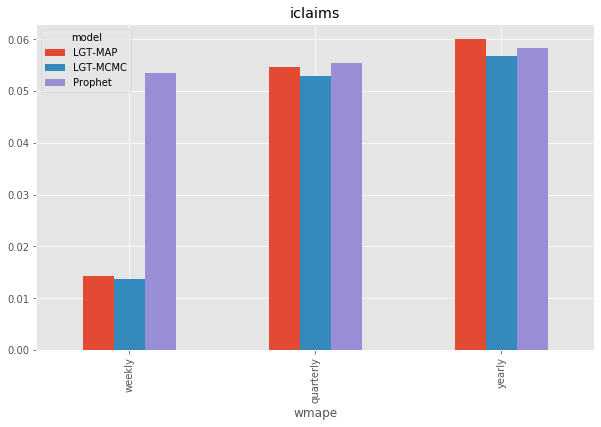

In [28]:
bt_summary.loc['iclaims'].unstack().iloc[[2,1,3],].apply(pd.to_numeric).plot(kind='bar', 
                                                                       stacked=False,
                                                                       figsize=(10,6), title='iclaims')

## (external) M4 challenge datasets

In [41]:
data_path = "./data/M4-weekly-train.csv"
raw_data = pd.read_csv(data_path)

data = raw_data.copy()
## select all series with no missing values
data = data[data.columns[~data.isna().any()]]

data['V1'] = pd.date_range(start='2012-08-06', periods=len(data), freq='W')
data = pd.melt(data, id_vars='V1')
data[['value']] = data[['value']].apply(np.log, axis = 1)
data.rename(columns={ 'V1': "week",
                      'variable': "city_name" }, inplace = True)

In [42]:
date_col = 'week'
resp_col = 'value'
min_train_len = 280
forecast_len = 52
incremental_len = 10

geo_col = 'city_name'
keep_cols = ['city_name']
city_name_list =  data['city_name'].unique()
scheme = 'expanding'
transform_fun = np.exp

# pred_cols = ['prediction', 50, 'yhat']
pred_cols = ['prediction', 'prediction', 'yhat']
model_callbacks = [None, None, model_callbacks_prophet]
fit_callbacks = [None, None, fit_callbacks_prophet]
pred_callbacks = [None, None, pred_callbacks_prophet]

mod_list = [ 
    
    ## vanilla LGT
    LGT(response_col = resp_col,
        date_col = date_col,
        seasonality = 52,
        seed = 1,
        predict_method = 'map'
),

#     LGT(response_col=resp_col,
#         date_col=date_col,
#         seasonality=52,
#         num_warmup=1000, 
#         num_sample=2000,
#         predict_method='full', ## full/mean/median/map, 
#         sample_method='mcmc',## vi
#         n_bootstrap_draws=-1,
#         seed = 1
# ),
    DLT(response_col=resp_col,
        date_col=date_col,
        seasonality=52,
        num_warmup=1000, 
        num_sample=2000,
        predict_method = 'map',
        damped_factor_fixed=-1,
        seed = 1
),
    ## fb prophet
    Prophet()
    
]

In [43]:
np.random.seed(2019)
wmape_dict_m4, bt_res_m4 = analyze_utility(data, geo_col, city_name_list, pred_cols,
                        mod_list, model_callbacks, fit_callbacks, pred_callbacks,
                        date_col, resp_col, min_train_len, incremental_len, forecast_len, 
                        transform_fun, metric_fun = 'smape',
                        start_date=None, end_date=None,
                        keep_cols = keep_cols,
                        mod_names = model_names, to_save_as = 'M4',
                        scheme = scheme)

 67%|██████▋   | 2/3 [00:00<00:00, 10.98it/s]

time elapsed 00:00:19


  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


time elapsed 00:00:31


 33%|███▎      | 1/3 [00:01<00:03,  2.00s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:04<00:02,  2.08s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:03<00:07,  3.57s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%

  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:01<00:03,  1.71s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.69s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎   

 33%|███▎      | 1/3 [00:01<00:03,  1.61s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.62s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:01<00:03,  1.70s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%

  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:01<00:03,  1.68s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.66s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎   

 33%|███▎      | 1/3 [00:01<00:03,  1.64s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%|██████▋   | 2/3 [00:03<00:01,  1.73s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
  0%|          | 0/3 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 33%|███▎      | 1/3 [00:01<00:03,  1.67s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
 67%

time elapsed 00:06:57
saving results to /Users/edwinng/work/uTS-super/uTS-py/uTS/examples/orbit_benchmark_results/orbit_benchmark_M4.pickle


In [46]:
for i, key in enumerate(wmape_dict_m4.keys()):
    bt_summary.iloc[3, list(range(i, bt_summary.shape[1], 3))] = \
                                [ wmape_dict_m4[key]['metric_weekly'],  
                                    wmape_dict_m4[key]['metric_quarterly'],
                                    wmape_dict_m4[key]['metric_yearly'],
                                    wmape_dict_m4[key]['exe_time'] ]
    
bt_summary.loc['M4'].to_frame()

M4
wmape     model            
weekly    LGT-MAP  0.142161
          DLT-MAP  0.181401
          Prophet  0.387598
quarterly LGT-MAP  0.570882
          DLT-MAP  0.557426
          Prophet  0.626504
yearly    LGT-MAP  0.602362
          DLT-MAP  0.577591
          Prophet  0.633417
exe_time  LGT-MAP  00:00:19
          DLT-MAP  00:00:31
          Prophet  00:06:57

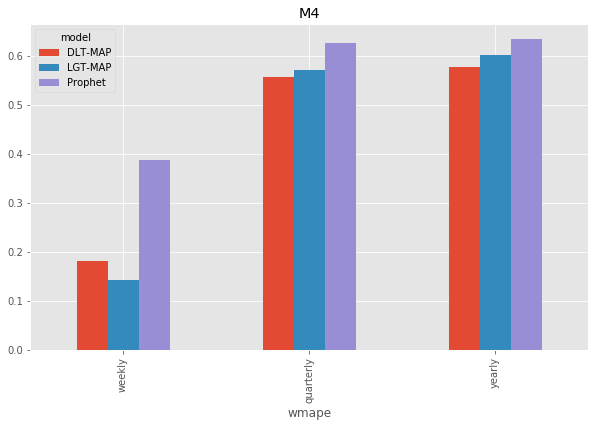

In [47]:
bt_summary.loc['M4'].unstack().iloc[[2,1,3],].apply(pd.to_numeric).plot(kind='bar', 
                                                                       stacked=False,
                                                                       figsize=(10,6), title='M4')

One can re-use the pickled results to do further analyses.

In [23]:
# with open('./orbit_benchmark_results/orbit_benchmark_M4.pickle', 'rb') as handle:
#     res = pickle.load(handle)
# print(res.keys())

## result summary

In [48]:
bt_summary

wmape       weekly                        quarterly                        \
model      LGT-MAP    DLT-MAP    Prophet    LGT-MAP    DLT-MAP    Prophet   
dataset                                                                     
driver   0.0473308  0.0471125  0.0597898  0.0794364  0.0796981  0.0966086   
rider    0.0193926  0.0178384  0.0136503  0.0403234   0.037246  0.0413404   
iclaims        NaN        NaN        NaN        NaN        NaN        NaN   
M4        0.142161   0.181401   0.387598   0.570882   0.557426   0.626504   

wmape       yearly                      exe_time                      
model      LGT-MAP   DLT-MAP   Prophet   LGT-MAP   DLT-MAP   Prophet  
dataset                                                               
driver    0.113997  0.132284  0.132051  00:00:10  00:00:13  00:03:56  
rider    0.0710126  0.087378  0.133919  00:00:10  00:00:15  00:03:44  
iclaims        NaN       NaN       NaN       NaN       NaN       NaN  
M4        0.602362  0.577591  0.633417  00:00:19  00:00:31  00:06:57